In [1]:
#import dependecies
import pandas as pd
import sqlite3
import warnings
warnings.filterwarnings('ignore')

import datetime
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

#import dependencies for ML models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score
from sklearn.svm import SVR
from sklearn.model_selection import validation_curve
import math
from math import sqrt


#import dependencies for graphs
import numpy as np
import matplotlib.pyplot as plt 
from scipy import stats
import seaborn as sns; sns.set_theme(color_codes=True)
sns.set_context("paper")


In [2]:
#connect to a sqlite3 db
conn = sqlite3.connect(r'/Users/rosaicelaroman/Desktop/portfolio_work/earthquake_modeling/Database/db/earthquake_db')
print("Connected to database...")

Connected to database...


In [3]:
model_df = pd.read_sql_query("SELECT * FROM earthquake_raw", conn)
model_df

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2022-01-06T01:42:39.855Z,37.3840,-117.1075,1.10,1.3,ml,8.0,149.46,0.875,0.2175,...,2022-01-06T01:47:19.317Z,"37 km SSE of Goldfield, Nevada",earthquake,NaN,39.1,0.290,4.0,automatic,nn,nn
1,2022-01-06T01:31:33.698Z,38.1810,-117.8180,7.30,1.4,ml,11.0,154.64,0.119,0.1017,...,2022-01-06T01:47:40.245Z,"34 km SE of Mina, Nevada",earthquake,NaN,2.0,0.460,5.0,automatic,nn,nn
2,2022-01-06T01:24:20.083Z,61.3407,-149.8852,30.00,1.5,ml,NaN,NaN,NaN,0.7500,...,2022-01-06T01:29:22.015Z,"5 km ESE of Point MacKenzie, Alaska",earthquake,NaN,0.2,NaN,NaN,automatic,ak,ak
3,2022-01-06T01:15:15.851Z,62.8703,-150.7625,111.30,2.1,ml,NaN,NaN,NaN,0.3200,...,2022-01-06T01:29:21.875Z,"41 km N of Petersville, Alaska",earthquake,NaN,0.8,NaN,NaN,automatic,ak,ak
4,2022-01-06T01:10:44.629Z,64.0145,-148.7657,1.90,1.5,ml,NaN,NaN,NaN,0.7200,...,2022-01-06T01:15:56.292Z,"17 km E of Ferry, Alaska",earthquake,NaN,0.6,NaN,NaN,automatic,ak,ak
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28330,2022-01-30T05:22:23.246Z,37.8445,144.8923,10.00,4.3,mb,NaN,126.00,4.178,0.7000,...,2022-02-26T10:52:54.040Z,"off the east coast of Honshu, Japan",earthquake,8.0,1.8,0.137,16.0,reviewed,us,us
28331,2022-01-30T05:08:20.279Z,-30.0533,-177.1517,10.00,4.3,mb,NaN,221.00,1.034,0.6800,...,2022-02-26T10:21:50.040Z,"Kermadec Islands, New Zealand",earthquake,10.8,2.0,0.160,12.0,reviewed,us,us
28332,2022-01-30T03:50:17.124Z,54.2336,-159.7370,22.54,3.0,ml,NaN,219.00,0.604,1.0300,...,2022-02-25T00:07:12.426Z,"132 km SSE of Sand Point, Alaska",earthquake,5.2,14.1,0.088,17.0,reviewed,us,us
28333,2022-01-30T03:46:53.207Z,63.2782,-151.2517,7.40,1.0,ml,NaN,NaN,NaN,0.6600,...,2022-02-25T00:07:27.831Z,"37 km SE of Denali National Park, Alaska",earthquake,NaN,0.2,NaN,NaN,reviewed,ak,ak


In [4]:
#converting time to datetime
model_df['time'] = pd.to_datetime(model_df['time'])
model_df

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2022-01-06 01:42:39.855000+00:00,37.3840,-117.1075,1.10,1.3,ml,8.0,149.46,0.875,0.2175,...,2022-01-06T01:47:19.317Z,"37 km SSE of Goldfield, Nevada",earthquake,NaN,39.1,0.290,4.0,automatic,nn,nn
1,2022-01-06 01:31:33.698000+00:00,38.1810,-117.8180,7.30,1.4,ml,11.0,154.64,0.119,0.1017,...,2022-01-06T01:47:40.245Z,"34 km SE of Mina, Nevada",earthquake,NaN,2.0,0.460,5.0,automatic,nn,nn
2,2022-01-06 01:24:20.083000+00:00,61.3407,-149.8852,30.00,1.5,ml,NaN,NaN,NaN,0.7500,...,2022-01-06T01:29:22.015Z,"5 km ESE of Point MacKenzie, Alaska",earthquake,NaN,0.2,NaN,NaN,automatic,ak,ak
3,2022-01-06 01:15:15.851000+00:00,62.8703,-150.7625,111.30,2.1,ml,NaN,NaN,NaN,0.3200,...,2022-01-06T01:29:21.875Z,"41 km N of Petersville, Alaska",earthquake,NaN,0.8,NaN,NaN,automatic,ak,ak
4,2022-01-06 01:10:44.629000+00:00,64.0145,-148.7657,1.90,1.5,ml,NaN,NaN,NaN,0.7200,...,2022-01-06T01:15:56.292Z,"17 km E of Ferry, Alaska",earthquake,NaN,0.6,NaN,NaN,automatic,ak,ak
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28330,2022-01-30 05:22:23.246000+00:00,37.8445,144.8923,10.00,4.3,mb,NaN,126.00,4.178,0.7000,...,2022-02-26T10:52:54.040Z,"off the east coast of Honshu, Japan",earthquake,8.0,1.8,0.137,16.0,reviewed,us,us
28331,2022-01-30 05:08:20.279000+00:00,-30.0533,-177.1517,10.00,4.3,mb,NaN,221.00,1.034,0.6800,...,2022-02-26T10:21:50.040Z,"Kermadec Islands, New Zealand",earthquake,10.8,2.0,0.160,12.0,reviewed,us,us
28332,2022-01-30 03:50:17.124000+00:00,54.2336,-159.7370,22.54,3.0,ml,NaN,219.00,0.604,1.0300,...,2022-02-25T00:07:12.426Z,"132 km SSE of Sand Point, Alaska",earthquake,5.2,14.1,0.088,17.0,reviewed,us,us
28333,2022-01-30 03:46:53.207000+00:00,63.2782,-151.2517,7.40,1.0,ml,NaN,NaN,NaN,0.6600,...,2022-02-25T00:07:27.831Z,"37 km SE of Denali National Park, Alaska",earthquake,NaN,0.2,NaN,NaN,reviewed,ak,ak


In [5]:
for col in model_df.columns:
    print(col)

time
latitude
longitude
depth
mag
magType
nst
gap
dmin
rms
net
id
updated
place
type
horizontalError
depthError
magError
magNst
status
locationSource
magSource


In [6]:
#drop columns not needed
cleaned_df = model_df.drop(columns=['id', 'nst','rms','magNst','net', 'time', 'magType', 'gap','dmin', 'updated', 'place', 'type', 'horizontalError', 'depthError', 'magError', 'status', 'locationSource', 'magSource'])
cleaned_df

,latitude,longitude,depth,mag
0,37.3840,-117.1075,1.10,1.3
1,38.1810,-117.8180,7.30,1.4
2,61.3407,-149.8852,30.00,1.5
3,62.8703,-150.7625,111.30,2.1
4,64.0145,-148.7657,1.90,1.5
...,...,...,...,...
28330,37.8445,144.8923,10.00,4.3
28331,-30.0533,-177.1517,10.00,4.3
28332,54.2336,-159.7370,22.54,3.0
28333,63.2782,-151.2517,7.40,1.0


In [7]:
#find if any column has NaNs
cleaned_df.isnull().sum()

latitude     0
longitude    0
depth        0
mag          6
dtype: int64

In [8]:
#drop NaNs
cleaned_df_dropped = cleaned_df.dropna()

In [9]:
#verify dropped NaNs
cleaned_df_dropped.isnull().sum()

latitude     0
longitude    0
depth        0
mag          0
dtype: int64

In [10]:
#establish features to be used in model. X will use: longitude, longitude, depth and unix time. Y will be magnitude
X = cleaned_df_dropped.drop(['longitude'], axis = 1)

y = cleaned_df_dropped[['longitude']]

In [11]:
#checking number of columns and rows for eacg feature
X.shape, y.shape

((28329, 3), (28329, 1))

In [12]:
#scale and transform the data
# sc_X = StandardScaler()
# sc_y = StandardScaler()
# X = X.fit_transform(X)
# y = y.fit_transform(y)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

Extra Trees Regressor

In [14]:
#create and run model: First with 50 estimators
scores = []
estimators_lst=[]

for i in range(1,50):
    model = ExtraTreesRegressor(n_estimators=i+1, random_state=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test,y_pred)

    r2 = r2_score(y_test, y_pred)
    score = model.score(X_test, y_test)
    estimators = i+1
    scores.append(score)
    estimators_lst.append(score)

    print("n_estimators={}:".format(estimators))
    print("\tMean Squared Error:", mse, end = ", ")
    print("\tR2 score:", r2, end = ", ")
    print("\tModel score:", score)
max_score = max(scores)
print("Max score:", max_score)
index_max_score = scores.index(max_score) #find the position in the list for max score to get the number of estimators
best_score = max_score
best_model = ExtraTreesRegressor(n_estimators=index_max_score+2, random_state=0)
best_model.fit(X_train, y_train)
best_model_score = best_model.score(X_test, y_test)
print("Best model score: ", best_model_score)


n_estimators=2:
	Mean Squared Error: 1349.4469875559482, 	R2 score: 0.7418646398070818, 	Model score: 0.7418646398070818
n_estimators=3:
	Mean Squared Error: 1271.401439678766, 	R2 score: 0.7567939521835674, 	Model score: 0.7567939521835674
n_estimators=4:
	Mean Squared Error: 1221.8056789444802, 	R2 score: 0.7662811122419064, 	Model score: 0.7662811122419064
n_estimators=5:
	Mean Squared Error: 1176.9575144074795, 	R2 score: 0.7748601058693014, 	Model score: 0.7748601058693014
n_estimators=6:
	Mean Squared Error: 1124.2982122733465, 	R2 score: 0.7849332899582306, 	Model score: 0.7849332899582306
n_estimators=7:
	Mean Squared Error: 1122.0724939510212, 	R2 score: 0.7853590470321429, 	Model score: 0.7853590470321429
n_estimators=8:
	Mean Squared Error: 1116.5835961993125, 	R2 score: 0.786409016842936, 	Model score: 0.786409016842936
n_estimators=9:
	Mean Squared Error: 1103.683501772176, 	R2 score: 0.7888766725212836, 	Model score: 0.7888766725212836
n_estimators=10:
	Mean Squared Error

In [15]:
#create and run model: Now with 200 max estimators if no improvement of the score is found
scores = []
counter = 0
import time
start_time = time.perf_counter()
for i in range(1,100):
    model = ExtraTreesRegressor(n_estimators=i+1, random_state=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test,y_pred)

    r2 = r2_score(y_test, y_pred)
    score = model.score(X_test, y_test)
    estimators = i+1
    current_score = score
    num_estimators = estimators

    print("n_estimators={}:".format(estimators))
    print("\tMean Squared Error:", mse, end = ", ")
    print("\tR2:", r2, end = ", ")
    print("\tModel score:", score)
    if current_score > best_score:
        best_score = current_score
        best_model = model
        num_estimators=i+1
        print('Improvement found!')
        counter = 0
    else:
        counter += 1
    if counter > 60:
        break

end_time = time.perf_counter()
execution_time = end_time - start_time

print(f'Best score found: {best_score:.3f}.')
print(f'Number of estimators: {num_estimators}.')
print(f'Code execution time: {execution_time:.3f} seconds.')

n_estimators=2:
	Mean Squared Error: 1349.4469875559482, 	R2: 0.7418646398070818, 	Model score: 0.7418646398070818
n_estimators=3:
	Mean Squared Error: 1271.401439678766, 	R2: 0.7567939521835674, 	Model score: 0.7567939521835674
n_estimators=4:
	Mean Squared Error: 1221.8056789444802, 	R2: 0.7662811122419064, 	Model score: 0.7662811122419064
n_estimators=5:
	Mean Squared Error: 1176.9575144074795, 	R2: 0.7748601058693014, 	Model score: 0.7748601058693014
n_estimators=6:
	Mean Squared Error: 1124.2982122733465, 	R2: 0.7849332899582306, 	Model score: 0.7849332899582306
n_estimators=7:
	Mean Squared Error: 1122.0724939510212, 	R2: 0.7853590470321429, 	Model score: 0.7853590470321429
n_estimators=8:
	Mean Squared Error: 1116.5835961993125, 	R2: 0.786409016842936, 	Model score: 0.786409016842936
n_estimators=9:
	Mean Squared Error: 1103.683501772176, 	R2: 0.7888766725212836, 	Model score: 0.7888766725212836
n_estimators=10:
	Mean Squared Error: 1102.3822535026177, 	R2: 0.7891255879613567, 	

Cross-Validation

In [16]:
#define number of splits
k_fold = KFold(n_splits=10)
for train_indices, test_indices in k_fold.split(X):
    print('Train: %s | test: %s' % (train_indices, test_indices))


Train: [ 2833  2834  2835 ... 28326 28327 28328] | test: [   0    1    2 ... 2830 2831 2832]
Train: [    0     1     2 ... 28326 28327 28328] | test: [2833 2834 2835 ... 5663 5664 5665]
Train: [    0     1     2 ... 28326 28327 28328] | test: [5666 5667 5668 ... 8496 8497 8498]
Train: [    0     1     2 ... 28326 28327 28328] | test: [ 8499  8500  8501 ... 11329 11330 11331]
Train: [    0     1     2 ... 28326 28327 28328] | test: [11332 11333 11334 ... 14162 14163 14164]
Train: [    0     1     2 ... 28326 28327 28328] | test: [14165 14166 14167 ... 16995 16996 16997]
Train: [    0     1     2 ... 28326 28327 28328] | test: [16998 16999 17000 ... 19828 19829 19830]
Train: [    0     1     2 ... 28326 28327 28328] | test: [19831 19832 19833 ... 22661 22662 22663]
Train: [    0     1     2 ... 28326 28327 28328] | test: [22664 22665 22666 ... 25494 25495 25496]
Train: [    0     1     2 ... 25494 25495 25496] | test: [25497 25498 25499 ... 28326 28327 28328]


In [17]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cv_score=cross_val_score(best_model, X, y.values.ravel(), cv=k_fold, n_jobs=-1)
    print(cv_score)

[0.71985162 0.79873453 0.65830975 0.7600618  0.72965725 0.76599562
 0.83192211 0.77859909 0.7696133  0.73085851]


In [18]:
reg_etrees = ExtraTreesRegressor(n_estimators=100, random_state=0)

In [19]:
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html
param_range = np.linspace(1, 100, 5, dtype=int)
train_scores, test_scores = validation_curve(
    reg_etrees,
    X,
    y.values.ravel(),
    param_name="n_estimators",
    param_range=param_range,
    n_jobs=2,
    cv=10
)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

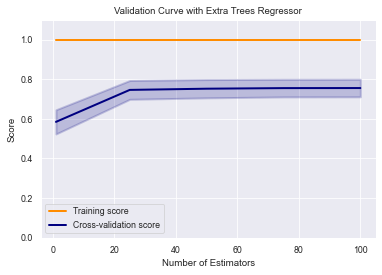

In [20]:

plt.title("Validation Curve with Extra Trees Regressor")
plt.xlabel("Number of Estimators")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.plot(
    param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
)
plt.fill_between(
    param_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)
plt.plot(
    param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
)
plt.fill_between(
    param_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="navy",
    lw=lw,
)
plt.legend(loc="best")
plt.show()

In [21]:
testpred = best_model.predict(X_test)
actual_lon = y_test
testpredict = []
for item in testpred:
    testpredict.append(item)

test_mse = mean_squared_error(y_test, testpred)
rmse = sqrt(test_mse)
print('RMSE: %f' % rmse)

RMSE: 31.557528


In [22]:
print(actual_lon)

        longitude
8870  -110.388333
3587  -112.381000
6356   -71.555500
11228  122.982900
2900  -148.337100
...           ...
5282  -119.467700
13082 -117.802500
21509 -116.567667
25047 -121.159667
19987 -165.899200

[9349 rows x 1 columns]


In [23]:
lon_pred = actual_lon
lon_pred['Predicted'] = testpredict


In [24]:
lon_pred_all = lon_pred.rename(columns={'longitude': 'Actual'})

In [25]:
lon_pred_all

,Actual,Predicted
8870,-110.388333,-110.656347
3587,-112.381000,-117.555111
6356,-71.555500,-164.892541
11228,122.982900,100.341352
2900,-148.337100,-149.027774
...,...,...
5282,-119.467700,-119.869323
13082,-117.802500,-117.738517
21509,-116.567667,-116.513923
25047,-121.159667,-116.193782


In [26]:
lon_pred_all = lon_pred.merge(model_df, how='inner', left_index=True, right_index=True)
lon_pred_all = lon_pred_all.rename(columns={'longitude_x': 'Actual', 'longitude_y': 'longitude'})
lon_pred_all

,Actual,Predicted,time,latitude,longitude,depth,mag,magType,nst,gap,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
8870,-110.388333,-110.656347,2022-01-20 23:40:46.420000+00:00,44.371333,-110.388333,8.00,0.19,md,11.0,129.00,...,2022-01-21T15:17:45.560Z,"65 km ESE of West Yellowstone, Montana",earthquake,0.41,0.62,0.183,5.0,reviewed,uu,uu
3587,-112.381000,-117.555111,2021-12-22 13:12:47+00:00,38.230500,-112.381000,8.81,1.95,ml,23.0,185.00,...,2021-12-22T14:36:48.510Z,"11 km NW of Circleville, Utah",earthquake,0.59,0.74,0.116,8.0,reviewed,uu,uu
6356,-71.555500,-164.892541,2021-12-14 04:23:55.138000+00:00,-28.686100,-71.555500,17.79,5.50,mwr,NaN,65.00,...,2021-12-27T03:25:09.775Z,"78 km W of Vallenar, Chile",earthquake,4.20,3.30,NaN,NaN,reviewed,us,guc
11228,122.982900,100.341352,2022-01-13 10:01:22.570000+00:00,1.481900,122.982900,28.19,4.70,mb,NaN,57.00,...,2022-01-20T10:10:39.040Z,"104 km N of Gorontalo, Indonesia",earthquake,6.50,5.90,0.147,14.0,reviewed,us,us
2900,-148.337100,-149.027774,2021-12-24 20:15:05.365000+00:00,62.446400,-148.337100,33.50,1.70,ml,NaN,NaN,...,2021-12-24T20:20:12.766Z,"72 km N of Chickaloon, Alaska",earthquake,NaN,0.20,NaN,NaN,automatic,ak,ak
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5282,-119.467700,-119.869323,2021-12-17 13:30:12.501000+00:00,38.556100,-119.467700,6.70,0.90,ml,6.0,150.19,...,2021-12-18T02:37:27.639Z,California-Nevada border region,earthquake,NaN,2.90,0.370,2.0,reviewed,nn,nn
13082,-117.802500,-117.738517,2022-01-08 09:26:27.250000+00:00,36.024333,-117.802500,0.49,-0.65,ml,7.0,112.00,...,2022-01-10T16:51:08.866Z,"13km E of Coso Junction, CA",earthquake,0.26,0.94,0.119,3.0,reviewed,ci,ci
21509,-116.567667,-116.513923,2022-02-24 17:41:27.130000+00:00,33.471333,-116.567667,10.08,0.29,ml,14.0,136.00,...,2022-02-24T23:29:21.422Z,"14km SE of Anza, CA",earthquake,0.23,0.42,0.116,11.0,reviewed,ci,ci
25047,-121.159667,-116.193782,2022-02-13 05:04:17.780000+00:00,36.570833,-121.159667,3.61,1.22,md,19.0,119.00,...,2022-02-16T02:52:13.784Z,"5km NNW of Pinnacles, CA",earthquake,0.33,0.23,0.286,14.0,reviewed,nc,nc


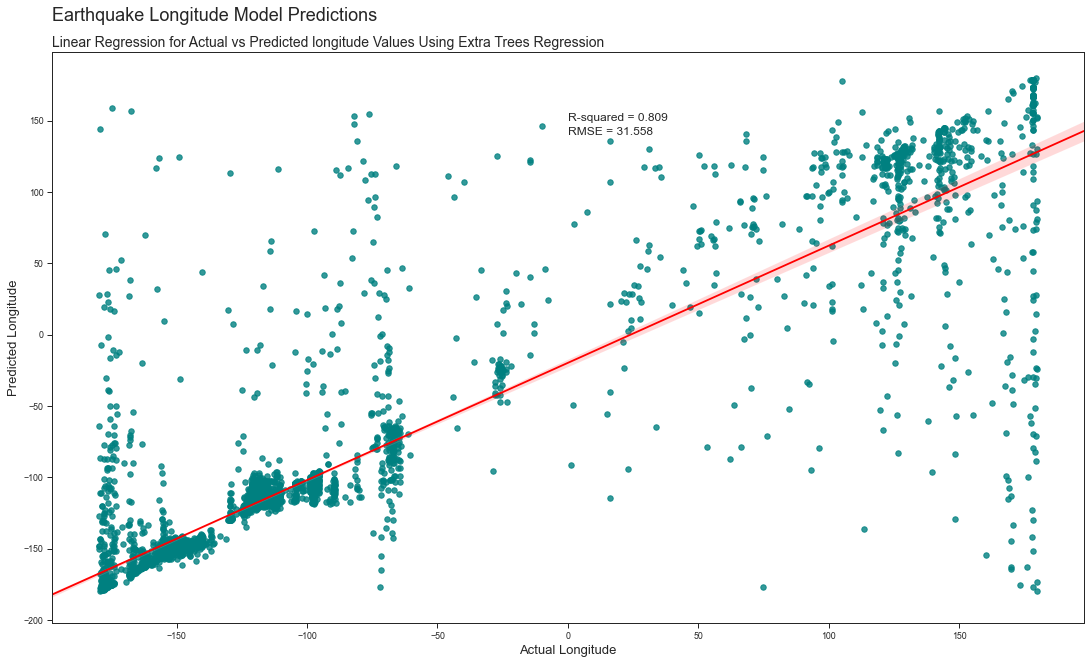

In [27]:
x = np.array(lon_pred_all['longitude'])
y = np.array(testpredict)
# r2_score(y_test, y_pred)

sns.set_style('ticks')
x,y = pd.Series(x, name="Actual"), pd.Series(y, name="Prediction")
# sns.lmplot(x ='Actual', y ='Prediction', data = mag_pred_all, markers =['o'],  palette ='coolwarm')
ax = sns.regplot(x=x, y=y, ci=95, truncate=False, scatter_kws={"s": 30, "color":'teal'}, line_kws={"color": "red"})
ax.set_axisbelow(True)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5, forward=True)
plt.ylabel('Predicted Longitude', fontsize=13)
plt.xlabel('Actual Longitude',  fontsize=13)
# Bigger title
plt.suptitle('Earthquake Longitude Model Predictions', x=0.125, y=0.94, ha='left', fontsize=18)
# Subtitle
plt.title('Linear Regression for Actual vs Predicted longitude Values Using Extra Trees Regression', loc='left', fontsize=14)
plt.annotate("R-squared = {:.3f}".format(r2_score(lon_pred_all['longitude'], testpredict)), (0, 150),  fontsize=12)
plt.annotate("RMSE = {:.3f}".format(rmse), (0, 140), fontsize=12)

# fig.savefig('extratrees_mag_linear_sns.png', dpi=600)
plt.show()

Test with new data from USGS


In [28]:

page_url = "https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/all_day.csv"

test_df = pd.read_csv(page_url)
test_df


,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2022-03-11T16:38:34.040Z,19.337500,-155.177826,3.99,2.17,ml,43.0,81.0,NaN,0.19,...,2022-03-11T16:44:04.740Z,"13 km SSE of Volcano, Hawaii",earthquake,0.44,1.58,0.210000,11.0,automatic,hv,hv
1,2022-03-11T16:38:21.960Z,38.831333,-122.810669,1.55,0.85,md,7.0,139.0,0.00794,0.01,...,2022-03-11T16:46:10.593Z,"8km NW of The Geysers, CA",earthquake,0.54,1.97,NaN,1.0,automatic,nc,nc
2,2022-03-11T16:31:55.854Z,59.754200,-153.094300,107.00,0.90,ml,NaN,NaN,NaN,0.29,...,2022-03-11T16:39:58.387Z,"56 km E of Pedro Bay, Alaska",earthquake,NaN,0.60,NaN,NaN,automatic,ak,ak
3,2022-03-11T16:28:12.690Z,36.601002,-121.190498,7.07,1.56,md,11.0,127.0,0.02953,0.06,...,2022-03-11T16:45:17.442Z,"9km NNW of Pinnacles, CA",earthquake,0.53,0.58,0.170000,7.0,automatic,nc,nc
4,2022-03-11T16:16:57.088Z,-21.582400,170.546600,146.88,4.80,mb,NaN,98.0,3.05200,0.90,...,2022-03-11T16:32:57.040Z,"261 km SSE of Isangel, Vanuatu",earthquake,5.70,7.40,0.074000,56.0,reviewed,us,us
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,2022-03-10T17:39:00.450Z,35.882500,-117.678000,7.01,0.69,ml,13.0,86.0,0.06901,0.11,...,2022-03-10T18:59:58.037Z,"22km ESE of Little Lake, CA",earthquake,0.18,0.42,0.024000,4.0,reviewed,ci,ci
212,2022-03-10T17:30:25.380Z,45.370333,-121.703833,0.55,0.76,ml,8.0,110.0,0.01182,0.07,...,2022-03-10T18:46:13.700Z,"8 km NNE of Government Camp, Oregon",earthquake,0.38,0.28,0.056599,4.0,reviewed,uw,uw
213,2022-03-10T17:04:07.430Z,34.025500,-117.121167,6.75,1.19,ml,40.0,102.0,0.01232,0.18,...,2022-03-10T18:58:29.815Z,"5km SSE of Mentone, CA",earthquake,0.19,0.37,0.145000,24.0,reviewed,ci,ci
214,2022-03-10T17:01:33.060Z,39.419667,-110.304000,-2.78,1.88,md,7.0,198.0,0.01693,0.13,...,2022-03-10T17:18:05.253Z,"16 km SSE of Sunnyside, Utah",earthquake,1.12,2.71,0.296000,6.0,reviewed,uu,uu


In [29]:

cleaned_test_df = test_df.drop(columns=['id', 'nst','rms','magNst','net', 'time', 'magType', 'gap','dmin', 'updated', 'place', 'type', 'horizontalError', 'depthError', 'magError', 'status', 'locationSource', 'magSource'])
cleaned_test_df



,latitude,longitude,depth,mag
0,19.337500,-155.177826,3.99,2.17
1,38.831333,-122.810669,1.55,0.85
2,59.754200,-153.094300,107.00,0.90
3,36.601002,-121.190498,7.07,1.56
4,-21.582400,170.546600,146.88,4.80
...,...,...,...,...
211,35.882500,-117.678000,7.01,0.69
212,45.370333,-121.703833,0.55,0.76
213,34.025500,-117.121167,6.75,1.19
214,39.419667,-110.304000,-2.78,1.88


In [30]:

#find if any column has NaNs
cleaned_test_df.isnull().sum()


latitude     0
longitude    0
depth        0
mag          0
dtype: int64

In [31]:

#establish features to be used in model. X will use: latitude, longitude, depth and unix time. Y will be magnitude
X_test_data = cleaned_test_df.drop(['longitude'], axis = 1)

y_test_data = cleaned_test_df[['longitude']]


In [32]:

pred_data_y = best_model.predict(X_test_data)


In [33]:

test_pred_data = cleaned_test_df
test_pred_data['Predicted'] = pred_data_y
test_pred_data


,latitude,longitude,depth,mag,Predicted
0,19.337500,-155.177826,3.99,2.17,-155.169880
1,38.831333,-122.810669,1.55,0.85,-122.813916
2,59.754200,-153.094300,107.00,0.90,-153.221326
3,36.601002,-121.190498,7.07,1.56,-113.882418
4,-21.582400,170.546600,146.88,4.80,-93.018538
...,...,...,...,...,...
211,35.882500,-117.678000,7.01,0.69,-116.441795
212,45.370333,-121.703833,0.55,0.76,-113.459320
213,34.025500,-117.121167,6.75,1.19,-117.334661
214,39.419667,-110.304000,-2.78,1.88,-110.300019


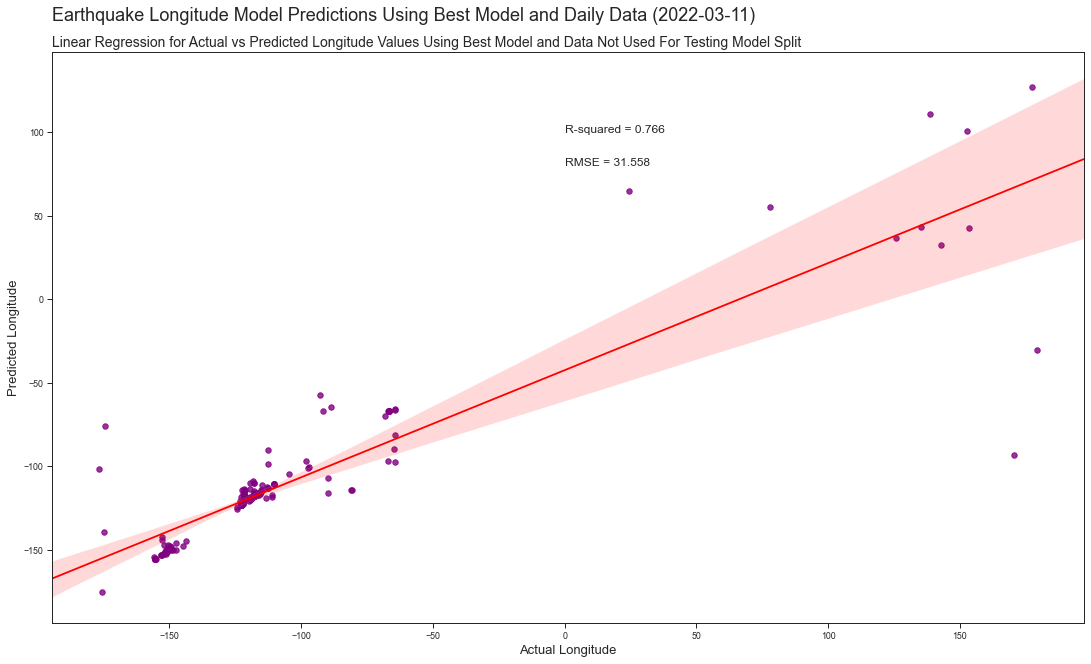

In [34]:
from datetime import date
today = date.today()

x = np.array(test_pred_data['longitude'])
y = np.array(test_pred_data['Predicted'])

sns.set_style('ticks')
x,y = pd.Series(x, name="Actual"), pd.Series(y, name="Prediction")
# sns.lmplot(x ='Actual', y ='Prediction', data = mag_pred_all, markers =['o'],  palette ='coolwarm')
ax = sns.regplot(x=x, y=y, ci=95, truncate=False, scatter_kws={"s": 30, "color":'purple'}, line_kws={"color": "red"})
ax.set_axisbelow(True)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5, forward=True)
plt.ylabel('Predicted Longitude', fontsize=13)
plt.xlabel('Actual Longitude',  fontsize=13)
# Bigger title
plt.suptitle(f'Earthquake Longitude Model Predictions Using Best Model and Daily Data ({today})', x=0.125, y=0.94, ha='left', fontsize=18)
# Subtitle
plt.title('Linear Regression for Actual vs Predicted Longitude Values Using Best Model and Data Not Used For Testing Model Split', loc='left', fontsize=14)
plt.annotate("R-squared = {:.3f}".format(r2_score(x, y)), (0, 100),  fontsize=12)
plt.annotate("RMSE = {:.3f}".format(rmse), (0, 80), fontsize=12)

# fig.savefig('extratrees_mag_linear_sns.png', dpi=600)
plt.show()

In [35]:
#connection to a PostgreSQL local database
# ===========================================

# user_name_var = input('What is the username of your database? ')
host_var = input('What is the host address of your database?')
pw = input("Enter the database password: ")
# db_name = input("Enter the name of the database: ")

string_output = "postgresql://postgres"+':'+pw+'@'+host_var+":5432"+'/earthquake_db'
engine = create_engine(string_output)
connection = engine.connect()
print("Connected to database...")
#create new database with predicted values for both training and test databases
#=============
#PostgreSQL
lon_pred_all.to_sql('earthquake_etrees_lon_notime', engine, if_exists='replace', index = False)
#=============
#SQLite
cur = conn.cursor()
lon_pred_all.to_sql('earthquake_etrees_lon_notime', conn, if_exists='replace', index=False)
# Close connection to SQLite database
conn.close()
connection.close()

Connected to database...
